# Generate Model Climatology

---

This notebook takes in the `.zarr` raw S2S array we made in `1_download_data.ipynb` and generates a daily climatology (with band pass filtering) to remove from the raw S2S output to create anomalies.

In [1]:
import numpy as np
import xarray as xr
xr.set_options(keep_attrs=True)
import dask.array as da
import cftime
from datetime import datetime

from dask.distributed import Client

In [2]:
client = Client("tcp://10.12.206.54:36593")

Choose which model and variables you are wanting in your climatology `zarr` file.

In [28]:
model = "ECCC" #ECMWF, NCEP, or ECCC
var = ["t2m","tp","gh_500"]
if model == "ECMWF" or model == "ECCC":
    days = 97
elif model == "NCEP":
    days = 94

First, we need to calculate the daily climatology following the SubX protocol. We'll load in our big `zarr`, take the ensemble mean, and then generate the climatology.

In [29]:
ds = xr.open_zarr("/glade/campaign/mmm/c3we/jaye/S2S_zarr/"+model+".raw.daily.geospatial.zarr",consolidated=True)
display(ds)

,Array,Chunk
Bytes,15.76 GB,119.40 MB
Shape,"(4, 1060, 32, 121, 240)","(4, 1060, 32, 11, 20)"
Count,133 Tasks,132 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,15.76 GB,119.40 MB
Shape,"(4, 1060, 32, 121, 240)","(4, 1060, 32, 11, 20)"
Count,133 Tasks,132 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


Here I "persist" the ensemble mean. This essentially runs the calculation in the background, but maintains the result as dask arrays distributed across the cluster, rather than loading it into RAM memory on the main node.

In [30]:
ds = ds.mean("member").persist()

## Generate Climatology

We'll be taking an average over the `dayofyear` of the `init` dimension, so it's best to rechunk so that `init` is a single chunk. That will speed things up. I'll make `lead` chunks of 1 since we are doing a lead-dependent climatology.

I usually run `.persist()` after re-chunking so that it can re-load it's chunks properly.

In [31]:
ds = ds.chunk({"init": -1, "lead": 1, "lat": "auto", "lon": "auto"}).persist()

All of the following is from Ray Bell's climatology script for SubX that Kathy uses. Direct questions to them about the methodology! This uses a smoothed window approach to smooth out the daily climatology for initializations.

In [32]:
ds.groupby("init.dayofyear").mean("init")

,Array,Chunk
Bytes,360.56 MB,116.16 kB
Shape,"(97, 32, 121, 240)","(1, 1, 121, 240)"
Count,15552 Tasks,3104 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,360.56 MB,116.16 kB
Shape,"(97, 32, 121, 240)","(1, 1, 121, 240)"
Count,15552 Tasks,3104 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


## Loop through all vars to make climatology

In [34]:
da_day_clim_smooth_vars = []
for i in var:
    print(i)
    da_day_clim = ds[i].groupby("init.dayofyear").mean("init")
    #da_day_clim = ds[i].groupby("init.dayofyear").mean("init")
    # Rechunk to make dayofyear climatology one chunk.
    da_day_clim = da_day_clim.chunk({"dayofyear": days}).persist()
    # Just mimicking the chunk sizes from our climatology.
    x = da.full((days, da_day_clim.lead.size, da_day_clim.lat.size, da_day_clim.lon.size),
        np.nan,dtype="float32",chunks=(days, 1, 121, 120),)
    # Pad the daily climatolgy with nans
    _da = xr.DataArray(x,dims=["dayofyear", "lead", "lat", "lon"],
        coords=[da_day_clim.dayofyear, da_day_clim.lead, da_day_clim.lat, da_day_clim.lon],name=i,)
    # Pad the daily climatolgy with nans
    da_day_clim_wnan = da_day_clim.combine_first(_da)
    # Period rolling twice to make it triangular smoothing
    da_day_clim_smooth = da_day_clim_wnan.copy()
    
    for j in range(2):
        # Extand the DataArray to allow rolling to do periodic
        da_day_clim_smooth = xr.concat([da_day_clim_smooth[-15:], da_day_clim_smooth, da_day_clim_smooth[:15]],"dayofyear",)
        # Rolling mean
        da_day_clim_smooth = da_day_clim_smooth.rolling(dayofyear=31, center=True, min_periods=1).mean()
        # Drop the periodic boundaries
        da_day_clim_smooth = da_day_clim_smooth.isel(dayofyear=slice(15, -15))
        
    # Extract the original days
    da_day_clim_smooth = da_day_clim_smooth.sel(dayofyear=da_day_clim.dayofyear)
    da_day_clim_smooth.name = i
    
    da_day_clim_smooth_vars.append(da_day_clim_smooth)

t2m
tp
gh_500


- Next we need to merge the variables together into one xarray dataset.

In [35]:
ds_day_clim_smooth_vars = xr.merge(da_day_clim_smooth_vars)

In [36]:
ds_day_clim_smooth_vars

,Array,Chunk
Bytes,721.12 MB,9.41 MB
Shape,"(97, 32, 121, 240)","(81, 1, 121, 120)"
Count,15204 Tasks,128 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,721.12 MB,9.41 MB
Shape,"(97, 32, 121, 240)","(81, 1, 121, 120)"
Count,15204 Tasks,128 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


- Now we write out to `zarr`!

In [37]:
%time ds_day_clim_smooth_vars.to_zarr("/glade/campaign/mmm/c3we/jaye/S2S_zarr/"+model+".climatology.daily.geospatial.zarr", mode="w",consolidated=True)

CPU times: user 5.94 s, sys: 8.61 s, total: 14.6 s
Wall time: 60 s


Just a quick check that things look right. It's going to look a bit stair-steppy because we only have inits every seven days

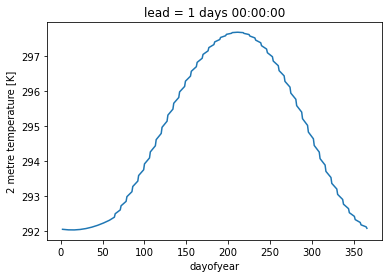

In [38]:
ds_day_clim_smooth_vars.t2m.isel(lead=0,lat=slice(31,60)).mean(("lat","lon")).plot()